<a href="https://colab.research.google.com/github/Andiko-K/SkinColorDetection/blob/main/transfer-learning/TfHubTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib.request
import zipfile
import os, shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

import random
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Installing Dataset

In [ ]:
!gdown --id 1Q6Li-WpLd277mByjoDRUhjCCiTVhcYxT

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Q6Li-WpLd277mByjoDRUhjCCiTVhcYxT
From (redirected): https://drive.google.com/uc?id=1Q6Li-WpLd277mByjoDRUhjCCiTVhcYxT&confirm=t&uuid=4bad2994-f9a9-4a36-a63c-6c4a0ab5fca4
To: /content/mst_dataset.zip
100% 313M/313M [00:15<00:00, 20.1MB/s]


# Data Exploration

In [ ]:
local_file = 'mst_dataset.zip'
destination = './mst_datasets/'

zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall(destination)
zip_ref.close()

In [ ]:
original_dir = './mst_datasets'
number_dir = sorted(os.listdir(original_dir))
num_file = []
for d in number_dir:
  sub_dir = os.path.join(original_dir, d)
  num_file.append(len(os.listdir(sub_dir)))

Text(0.5, 1.0, 'Number of Image Sample')

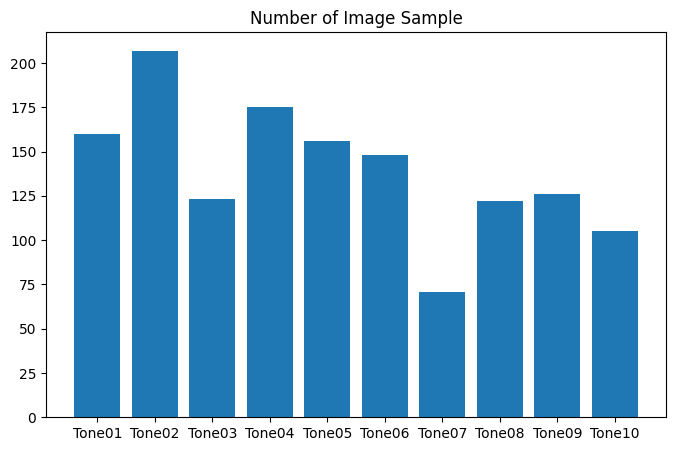

In [ ]:
plt.figure(figsize = (8, 5))
plt.bar(number_dir, num_file)
plt.title('Number of Image Sample')

Reccomendation: SMOTE for Tone 07 (?)

# Data Splitting

In [ ]:
original_dir = './mst_datasets'
def split_data(original_dir = original_dir, train_split = None,
               train_num = None, val_num = None):
  train_dir = './datasets/train/'
  val_dir = './datasets/validation'

  os.makedirs(train_dir, exist_ok = True)
  os.makedirs(val_dir, exist_ok = True)

  for category in os.listdir(original_dir):
    train_cat_dir = os.path.join(train_dir, category)
    val_cat_dir = os.path.join(val_dir, category)

    os.makedirs(train_cat_dir, exist_ok = True)
    os.makedirs(val_cat_dir, exist_ok = True)

    #Get Images List and Shuffle
    category_dir = os.path.join(original_dir, category)
    images = os.listdir(category_dir)
    random.shuffle(images)

    #Split images if train_split is specified
    if train_split is not None:
      split_index = int(train_split*len(images))
      train_images = images[:split_index]
      val_images = images[split_index:]

    #Split images if number of train and val is specified
    else:
      get_images = random.sample(images, train_num + val_num)
      train_images = get_images[:train_num]
      val_images = get_images[train_num:]

    #Replacing The File
    for image in train_images:
        src = os.path.join(category_dir, image)
        dest = os.path.join(train_dir, category, image)
        os.rename(src, dest)

    for image in val_images:
        src = os.path.join(category_dir, image)
        dest = os.path.join(val_dir, category, image)
        os.rename(src, dest)

  return train_dir, val_dir




In [ ]:
train_dir, val_dir = split_data(train_num = 50, val_num = 10)

# List Tensorflow Hub Model for Training Purposes

In [ ]:
model_hub = {
    'mobilev3large': ('https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/large-075-224-feature-vector/1', 224),
    'mobilev3small': ('https://www.kaggle.com/models/google/mobilenet-v3/TensorFlow2/small-075-224-feature-vector/1', 224),
    'mobilev2': ('https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-feature-vector/2', 128),
    'effnetv2': ("https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2", 224),
    'inceptionv3': ("https://www.kaggle.com/models/google/inception-v3/TensorFlow2/feature-vector/2", 299),
    'resnetv2': ("https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/101-classification/2", 224)
}

# Define Generator

In [ ]:
def image_generator(train_dir = train_dir, val_dir = val_dir, transfer_model = None,
                    batch_size = 32):
  module_handle, shape = transfer_model
  training_datagen = ImageDataGenerator(
      rescale = 1./255,
      horizontal_flip = True,
      zoom_range = .2,
      shear_range = .2,
      fill_mode = 'nearest'
  )
  train_generator = training_datagen.flow_from_directory(
      directory = train_dir,
      target_size = (shape, shape),
      batch_size = batch_size,
      class_mode = 'sparse'
  )

  validation_datagen = ImageDataGenerator(
      rescale = 1./255
  )
  val_generator = validation_datagen.flow_from_directory(
      directory = val_dir,
      target_size = (shape, shape),
      batch_size = batch_size,
      class_mode = 'sparse'
  )

  return train_generator, val_generator

# Define Model

In [ ]:
def create_model(transfer_model = None):
  module_handle, shape = transfer_model
  image_size = (shape, shape)
  feature_extractor = hub.KerasLayer(module_handle, input_shape = image_size + (3,))

  #For Testing, might as well set trainable to false
  model = tf.keras.Sequential([
      feature_extractor,
      tf.keras.layers.Dense(10, activation = 'softmax')
  ])

  optimizer = tf.keras.optimizers.SGD(learning_rate = .002, momentum = .9)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

# Train Model

In [ ]:
loss_l = []
acc_l = []
size_l = []

for transfer_model in model_hub.keys():
  train_generator, val_generator = image_generator(transfer_model = model_hub[transfer_model])
  model = create_model(transfer_model =model_hub[transfer_model])
  EPOCHS = 5
  model.fit(train_generator, epochs = EPOCHS,
                    validation_data = val_generator, verbose = 0)
  print(f'Training for {transfer_model} is complete!')
  model.save(f'./model/{transfer_model}.h5')

  evaluation = model.evaluate(val_generator)
  loss_l.append(evaluation[0]); acc_l.append(evaluation[1])

  size = os.path.getsize(f'./model/{transfer_model}.h5')/(10**6)
  size_l.append(size)

Found 492 images belonging to 10 classes.
Found 100 images belonging to 10 classes.
Training for mobilev3large is complete!
1/4 [======>.......................] - ETA: 0s - loss: 0.7042 - accuracy: 0.9688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 83ms/step - loss: 0.6901 - accuracy: 0.9400
Found 492 images belonging to 10 classes.
Found 100 images belonging to 10 classes.
Training for mobilev3small is complete!
2/4 [==============>...............] - ETA: 0s - loss: 0.6727 - accuracy: 0.9062

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 86ms/step - loss: 0.6382 - accuracy: 0.9200
Found 492 images belonging to 10 classes.
Found 100 images belonging to 10 classes.
Training for mobilev2 is complete!
4/4 [==============================] - 0s 72ms/step - loss: 0.4637 - accuracy: 0.9100
Found 492 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training for effnetv2 is complete!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 96ms/step - loss: 1.1321 - accuracy: 0.8500
Found 492 images belonging to 10 classes.
Found 100 images belonging to 10 classes.
Training for inceptionv3 is complete!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 313ms/step - loss: 0.7867 - accuracy: 0.8100
Found 492 images belonging to 10 classes.
Found 100 images belonging to 10 classes.
Training for resnetv2 is complete!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 108ms/step - loss: 0.2849 - accuracy: 0.8600


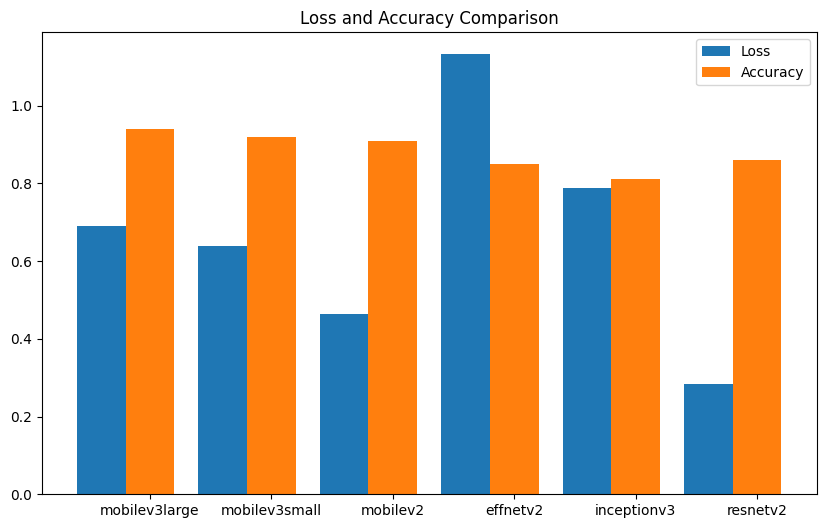

In [ ]:
categories = model_hub.keys()
num_categories = len(categories)

# Positions of the bars on the x-axis
bar_width = 0.4
indices = np.arange(num_categories)

# Positions for the grouped bars
indices1 = indices
indices2 = indices + bar_width
indices3 = indices + 2 * bar_width

# Create the bar plot
plt.figure(figsize=(10, 6))

plt.bar(indices1, loss_l, width=bar_width, label='Loss')
plt.bar(indices2, acc_l, width=bar_width, label='Accuracy')

# Add labels and title
plt.title('Models Evaluation For Train = 50 and Test = 10')
plt.title('Loss and Accuracy Comparison')
plt.xticks(indices + bar_width, categories)

# Add a legend
plt.legend()

# Show the plot
plt.show()

Text(0.5, 1.0, 'Size Comparison')

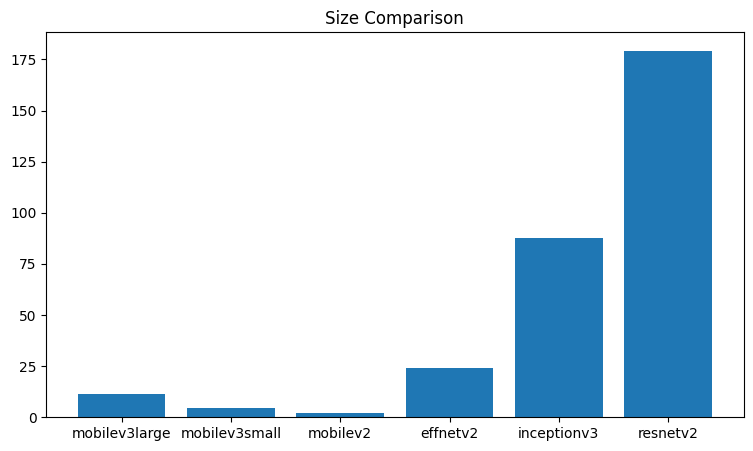

In [ ]:
plt.figure(figsize = (9, 5))
plt.bar(categories, size_l)
plt.title('Size Comparison')